In [97]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import urllib
import re
import collections
import spacy
import string
import html

In [16]:
LABELS = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

In [11]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"


root_dir = 'trainingandtestdata/'
train_file, test_file = 'trainingandtestdata/training.1600000.processed.noemoticon.csv', 'trainingandtestdata/testdata.manual.2009.06.14.csv'

In [17]:
train_data = pd.read_csv(train_file, encoding = DATASET_ENCODING, names=DATASET_COLUMNS, header=None)
test_data = pd.read_csv(test_file, encoding = DATASET_ENCODING, names=DATASET_COLUMNS, header = None)

In [20]:
## Length of the dataset 
print("Training Data size: ", len(train_data))
print("Test Data size: ", len(test_data))

Training Data size:  1600000
Test Data size:  498


<p> The train data contains 1.6M Tweets and the test data contains 498 tweets in total</p>

In [40]:
def get_histogram(data: np.ndarray, **kwargs): 
    title = kwargs.get("title", "train")
    labels, counts = np.unique(data, return_counts=True)
    fig, ax = plt.subplots()
    ax.set_title(f"Class Distribution: {title}")
    ax.bar(labels, counts, align='edge')
    if LABELS is not None: 
        ax.set_xticks(labels)
        ax.set_xticklabels([LABELS[idx] for idx in labels])
    ax.set_ylabel("COUNT")
    ax.set_xlabel("CLASS")
    return fig, ax

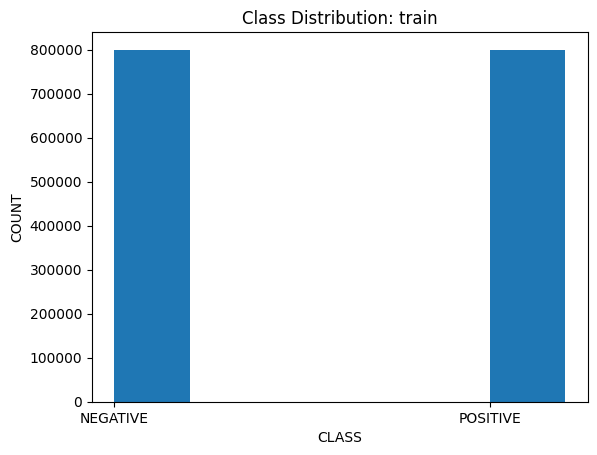

In [41]:
fig, ax = get_histogram(np.asarray(train_data['target']))

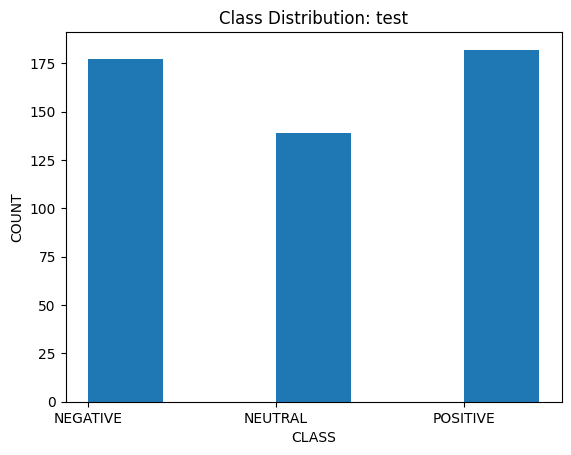

In [42]:
fig, ax = get_histogram(np.asarray(test_data['target']), title='test')

#### Observations
- Looking at the class distribution plots, we can conclude that the categories are __uniformly distributed__.
- Another interesting thing to note here is that the __neutral__ category is present only in the `test` dataset and not in the `train`. We can,
   - Completely __remove__ the __neutral__ category from the `test` while evaluating the model
   - Use a different scoring mechanism while training (which does not involve `softmax`) 

### Data Cleanup
<p> The objective from this section is to look for any non-speech related tokens (urls, @ mentions, emoticons) and remove them from the tweet. This process makes sure that the tweets only contain relevant information</p>

In [337]:
URL_PATTERN = r'https?://(?:[-\w.])+(?:[:\d]+)?(?:/(?:[\w/_.])*(?:\?(?:[\w&=%.])*)?(?:#(?:\w)*)?)?'
MENTION_PATTERN = r"@\w+"
EMAIL_PATTERN = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
EMOTICON_PATTERN = r"(?:[<>]?[:;=8xX][\-o*']?[\)\]\(\[dDpP/\:\}\{@\|\\])|(?:[\)\]\(\[dDpP/\:\}\{@\|\\][\-o*']?[:;=8xX][<>]?)|(?:[:;=8xX][\-o*']?[\(/{\[])|(?:[:;=8xX][\-o*]?['’][\(\[])"


def contains_emoticon(text: str): 
    emoticon_pattern = re.compile(EMOTICON_PATTERN)
    return bool(re.search(emoticon_pattern, text))

def contains_url(text: str): 
    return bool(re.search(URL_PATTERN, text))

def contains_mention(text: str): 
    return bool(re.search(MENTION_PATTERN, text))

def contains_email(text: str): 
    return bool(re.search(EMAIL_PATTERN, text))

def contains_multiple_marks(text: str): 
    exclamation_pattern = r"!{2,}"
    qmark_pattern = r"\?{2,}"
    return bool(re.search(exclamation_pattern, text) or re.search(qmark_pattern, text))

def contains_mark(text: str) -> bool:
    return bool(re.search(r"(^|[^!?])[!?](?![!?])", text))



def clean_text(text: str):
    text = re.sub(URL_PATTERN, '', text)
    text = re.sub(MENTION_PATTERN, '', text)
    text = re.sub(EMAIL_PATTERN, '', text)
    
    text = re.sub(r'^[^A-Za-z0-9]+', '', text)
    text = re.sub(r'!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)

    cleaned = ' '.join(text.split())
    return cleaned




In [296]:
train_data['cleaned_text'] = train_data['text'].apply(lambda x: clean_text(x))

In [313]:
train_data['char_len'] = train_data['text'].apply(lambda x: len(x))
train_data['word_len'] = train_data['text'].apply(lambda x: len([w for w in x.split(' ')]))

<Axes: ylabel='Density'>

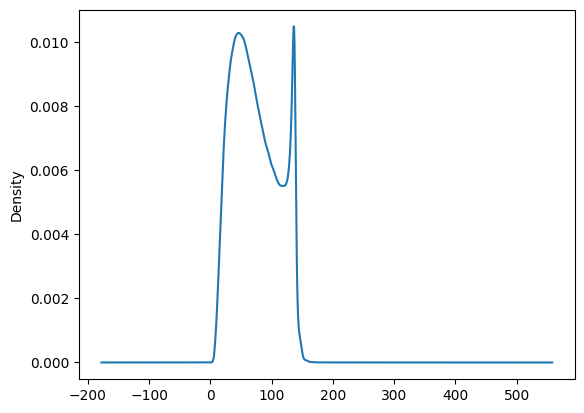

In [317]:
train_data['char_len'].plot(kind='kde')

In [290]:
sample_tweet = train_data['text'].loc[0]
print("Original tweet \n", sample_tweet)

cleaned_tweet = clean_text(sample_tweet)
print("Cleaned tweet \n", cleaned_tweet)

Original tweet 
 @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Cleaned tweet 
 Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D


In [288]:
positive_tweets = train_data[(train_data['target'] == 4)]['text'].tolist()
negative_tweets = train_data[(train_data['target'] == 0)]['text'].tolist()

In [187]:
def apply_contains(data: list[str], func): 
    contains_data = []
    for tweet in data: 
        if func(tweet): 
            contains_data.append(tweet)
    print(len(contains_data))
    return contains_data


In [227]:
apply_func = contains_emoticons
contains_positive = apply_contains(positive_tweets, apply_func)
contains_negative = apply_contains(negative_tweets, apply_func)

98465
71288


In [228]:
contains_positive[800]

'Night all.. just enjoyed a chat on connect2mums. Check it out.  http://connect2mums.ning.com/'

In [235]:
def top_used_emoticons(data: list[str]): 
    frequency_emoticons = collections.defaultdict(int)
    for tweet in data: 
        emoticons = re.findall(EMOTICON_PATTERN, tweet)
        for emo in emoticons: 
            frequency_emoticons[emo.lower()] += 1

    return frequency_emoticons

In [236]:
pos_emoticons = top_used_emoticons(positive_tweets)
neg_emoticons = top_used_emoticons(negative_tweets)

In [252]:
neg_emos = set(neg_emoticons.keys())
pos_emos = set(pos_emoticons.keys())

total_emos = neg_emos | pos_emos

In [263]:
emoticon_share = {}
for emo in total_emos: 
    emoticon_share[emo] = round((neg_emoticons.get(emo, 0)+1) / (pos_emoticons.get(emo, 0) + 1), 2)

In [291]:
train_data.cleaned_text = train_data['text'].apply(clean_text)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [98]:
nlp = spacy.load("en_core_web_sm", disable=["ner"])
stop_words = nlp.Defaults.stop_words
stop_lemmas = {"be", "have", "do"}

keep_pos = {"ADJ", "VERB", "NOUN", "PROPN"}

In [104]:
def top_frequent_words(data: list[str], k: int = 50, batch_size: int = 1000, processes: int = 1):
    frequent_words = collections.Counter()
    
    for doc in nlp.pipe((html.unescape(t) for t in data), batch_size=batch_size, n_process=processes):
        for tok in doc:
            if tok.is_space or tok.is_punct or tok.is_quote or tok.is_currency:
                continue
            if tok.is_stop or tok.like_num or tok.like_url or tok.like_email:
                continue
            if tok.pos_ not in keep_pos:
                continue
    
            lemma = tok.lemma_.lower().strip()
            if not lemma or lemma in stop_lemmas:
                continue
            if lemma.startswith("-pron-"):
                continue
    
            frequent_words[lemma] += 1

    return frequent_words.most_common(k)

In [107]:
positive_tweets = train_data[(train_data['target'] == 4)]['text'].tolist()[:100]
positive_tweet_words = top_frequent_words(positive_tweets)

In [139]:
# positive_tweet_words

In [321]:
train_data.describe()

,target,ids,char_len,word_len
count,1.600000e+06,1.600000e+06,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09,7.409011e+01,1.438213e+01
std,2.000001e+00,1.935761e+08,3.644114e+01,7.062139e+00
min,0.000000e+00,1.467810e+09,6.000000e+00,2.000000e+00
25%,0.000000e+00,1.956916e+09,4.400000e+01,9.000000e+00
50%,2.000000e+00,2.002102e+09,6.900000e+01,1.300000e+01
75%,4.000000e+00,2.177059e+09,1.040000e+02,2.000000e+01
max,4.000000e+00,2.329206e+09,3.740000e+02,1.100000e+02


In [338]:
train_data['cleaned_text'].apply(lambda x: contains_emoticon(x))

0           True
1          False
2          False
3          False
4          False
           ...  
1599995    False
1599996    False
1599997    False
1599998    False
1599999    False
Name: cleaned_text, Length: 1600000, dtype: bool

In [344]:
sample_tweet = train_data['cleaned_text'].loc[0]
SPECIALS = ["[PAD]", "[UNK]", "[CLS]", "[SEP]"]

In [359]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer, PorterStemmer

TT = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
stem_snowball = SnowballStemmer("english")
stem_porter = PorterStemmer()

SPECIALS = ["[PAD]", "[UNK]", "[CLS]", "[SEP]"]
PAD, UNK, CLS, SEP = SPECIALS

def tokenize(text: str):
    return TT.tokenize(text)


def build_vocab(texts: list[str], max_vocab: int = 30000, min_freq: int = 2):
    counter = collections.Counter()
    for s in texts:
        tokens = tokenize(s)
        toks = [stem_snowball.stem(t) for t in tokens]
        counter.update(toks)
    itos = SPECIALS + [w for w, c in counter.most_common() if c >= min_freq and w not in SPECIALS]
    if len(itos) > max_vocab:
        itos = itos[:max_vocab]
    stoi = {w: i for i, w in enumerate(itos)}
    return {"stoi": stoi, "itos": itos}



In [367]:
train_data['length'] = train_data['text'].apply(lambda x: len(tokenize(x)))

In [360]:
vocab = build_vocab(train_data['cleaned_text'].tolist())

In [377]:
def numericalize(tokens: list[str], stoi: dict):
    return [stoi.get(t, stoi[UNK]) for t in tokens]

def encode(text: str, stoi: dict, max_len: int = 128):
    ids = [stoi[CLS]]
    tokens = tokenize(text)
    ids += numericalize([stem_snowball.stem(t) for t in tokens], stoi)
    ids += [stoi[SEP]]

    if len(ids) > max_len:
        ids = ids[:max_len]
        ids[-1] = stoi[SEP]

    attn = [1] * len(ids)
    if len(ids) < max_len:
        pad_len = max_len - len(ids)
        ids += [stoi[PAD]] * pad_len
        attn += [0] * pad_len
    return {"input_ids": ids, "attention_mask": attn}

In [378]:
sample_tweet

"Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"

In [379]:
encoding = encode(sample_tweet, vocab['stoi'], max_len = 64)

In [382]:
len(tokenize(sample_tweet))

19

In [392]:
word = []
for _id in encoding['input_ids']: 
    word.append(vocab['itos'][_id]) 

In [393]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
detok = TreebankWordDetokenizer()
text = detok.detokenize(word)


In [394]:
text

'[CLS] awww, that a bummer . you shoulda got david carr of third day to do it .;d [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

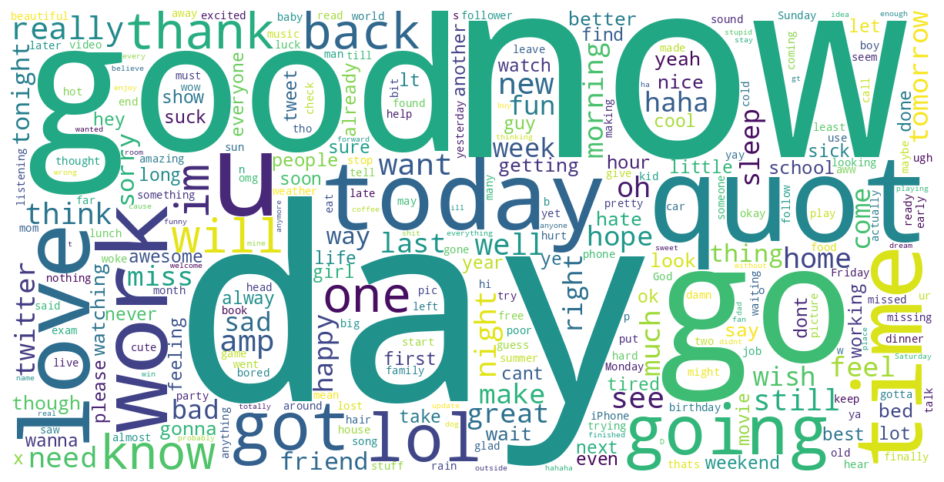

In [395]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# assume: train_data["cleaned_text"] exists
text = " ".join(map(str, train_data["cleaned_text"].tolist()))

# add any project-specific stopwords (keep negations!)
custom_stop = set(STOPWORDS) | {"rt", "via"}  # extend as you like

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    stopwords=custom_stop,
    max_words=300,
    collocations=False  # avoid bigrams like "new york" dominating unless you want them
).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [396]:
from utils import get_dataloaders

ModuleNotFoundError: No module named 'config'